In [1]:
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from sklearn import preprocessing

In [2]:
class Gaussian:

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.distr = tfp.distributions.Normal(self.mu, self.sigma)

    def pdf(self, x):
        return self.distr.prob(x)

    def cdf(self, x):
        return self.distr.cdf(x)

    def sample(self, n):
        return self.distr.sample(n)

In [3]:
np.random.seed(2)

nsamples = 1000
mu1 = -2 
sigma1 = 1 
f1 = Gaussian(mu1, sigma1)
w1 = 0.5
n1 = nsamples * w1
cluster1 = f1.sample(n1)

mu2 = 5
sigma2 = 1.5
f2 = Gaussian(mu2,  sigma2)
w2 = 0.2
n2 = nsamples * w2
cluster2 = f2.sample(n2)

mu3 = 12
sigma3 = 1
f3 = Gaussian(mu3, sigma3)
w3 = 0.3
n3 = nsamples * w3
cluster3 = f3.sample(n3)

print(f1.mu, f1.sigma, len(cluster1))
print(f2.mu, f2.sigma, len(cluster2))
print(f3.mu, f3.sigma, len(cluster3))

-2 1 500
5 1.5 200
12 1 300


In [4]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
print(gm.means_)
#array([[10.,  2.],
#       [ 1.,  2.]])
print(gm.predict([[0, 0], [12, 3]]))
#array([1, 0])

[[10.  2.]
 [ 1.  2.]]
[1 0]


c:\ProgramData\Anaconda3\envs\my-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


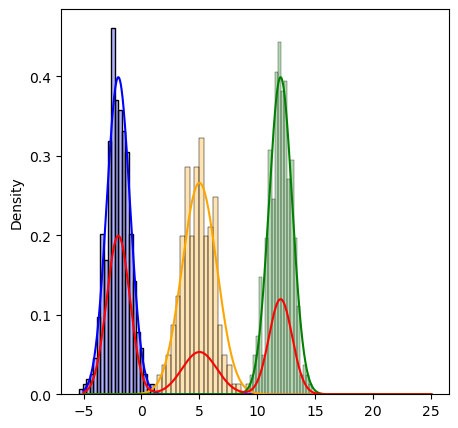

In [5]:
x = np.linspace(-5, 25, 1000)
fig = plt.figure(figsize=(5,5))


sns.histplot(cluster1, stat='density', alpha=0.3, color='blue')
plt.plot(x, f1.pdf(x), color='blue')
#plt.scatter(cluster_1, np.zeros(len(cluster_1)), color='red', marker='o')

sns.histplot(cluster2, stat='density', bins=20,alpha=0.3, color='orange',)
plt.plot(x, f2.pdf(x), color='orange')

sns.histplot(cluster3, stat='density', bins=20,alpha=0.3, color='green',)
plt.plot(x, f3.pdf(x), color='green')

plt.plot(x, w1*f1.pdf(x) + w2*f2.pdf(x) + w3*f3.pdf(x), color = 'red')

plt.show()


In [6]:
data = np.concatenate((cluster1.numpy(), cluster2.numpy(), cluster3.numpy()))
print(np.mean(data), np.var(data))

3.5299218 38.435917


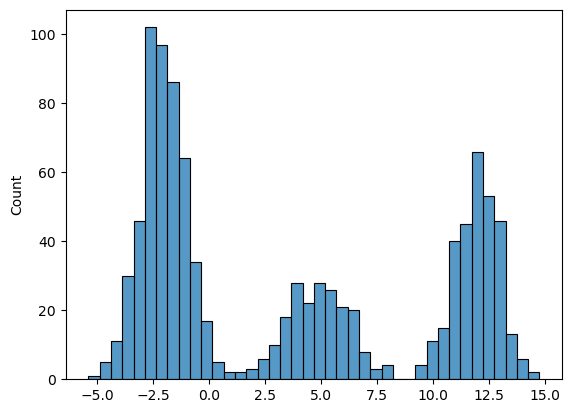

In [7]:
fig = plt.figure()

sns.histplot(data, bins=40)
plt.show()

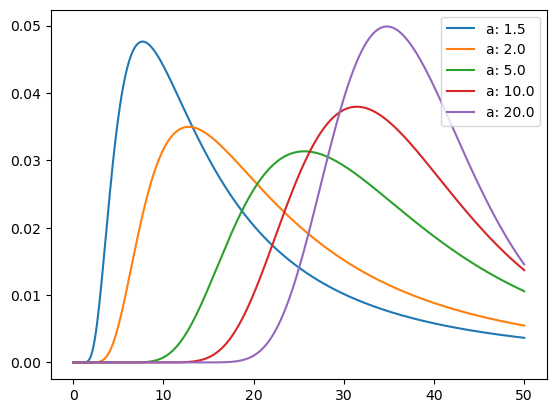

In [8]:
mu_hat= np.mean(data)
var_hat = np.var(data)

sigrange = np.linspace(0.001, 50, 1000)

for a in [1.5, 2.0, 5.0, 10.0, 20.0]:
    b = var_hat * (a - 1)
    plt.plot(sigrange, tfp.distributions.InverseGamma(a, b).prob(sigrange), label="a: {0}".format(a))

plt.legend()
plt.show()

In [9]:
a = 5
b = var_hat * (a)
print(b)

192.17958450317383


In [10]:
def Gibbs_Sampler(data, n_clus, niter, burnin):
    alpha = np.ones(n_clus) 
    weights = np.ones(n_clus) / n_clus
    cluster_allocs = tfp.distributions.Categorical(probs = weights).sample(len(data))

    cluster_allocs_out = []
    mu_out = []
    tau_out = []
    weights_out = []

    mu0 = np.mean(data)
    tau0 = tfp.distributions.Gamma(a,b).sample().numpy()

    for i in range(niter):
        print("\rIter {0} / {1}".format(i+1, niter), flush=True, end=" ")

        n_in_clus = np.sum(cluster_allocs == np.arange(n_clus)[:, np.newaxis], axis=1)
        weights = tfp.distributions.Dirichlet(alpha+n_in_clus).sample().numpy()
        
        mu_iter = []
        tau_iter = []

        # one step Gibbs
        for j in range(n_clus):
            clusdata = data[cluster_allocs == j]
            if len(clusdata) == 0:
                clusmean = 0
            else:
                clusmean = np.mean(clusdata)
        
            tau_clus = tfp.distributions.Gamma(a+len(clusdata)/2, b+0.5*(np.sum((clusdata-clusmean)**2))).sample().numpy()
            delta = (len(clusdata)*tau_clus) / (tau0 + len(clusdata)*tau_clus)
            mu_clus = tfp.distributions.Normal(delta*clusmean+(1-delta)*mu0, np.sqrt(1/(tau0+len(clusdata)*tau_clus))).sample().numpy()
    
            tau_iter.append(tau_clus)
            mu_iter.append(mu_clus)

        logprobs = tfp.distributions.Normal(mu_iter, np.sqrt(np.reciprocal(tau_iter))).log_prob(data[:, np.newaxis])
        probs = np.exp(np.log(weights) + logprobs)
        probs /= np.sum(probs, axis=1)[:, np.newaxis]
        cluster_allocs = tfp.distributions.Categorical(probs=probs).sample()
        
        if (niter > burnin):
            weights_out.append(weights)
            tau_out.append(tau_iter)
            mu_out.append(mu_iter)
            cluster_allocs_out.append(cluster_allocs)

    return cluster_allocs_out, mu_out, tau_out, weights_out

In [11]:
n_clus = 3
niter = 1000
burnin = 700
z, mu, tau, w = Gibbs_Sampler(data, n_clus, niter, burnin)

Iter 1000 / 1000                                                                                                                                      

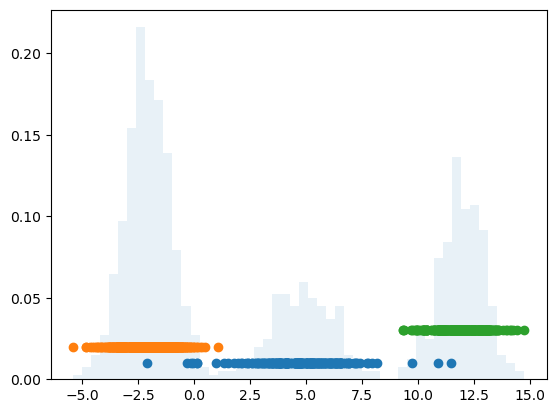

In [12]:
plt.hist(data, density=True, alpha=0.1, bins=50)
for h in range(3):
    currd = data[z[-1] == h]
    plt.scatter(currd,  np.zeros_like(currd) + 0.01 * (h+1))

In [13]:
np.mean(mu, axis=0)

array([ 4.9353882 , -2.03161772, 11.83151566])

In [27]:
mu0 = []
mu1 = []
mu2 = []

for i in range(len(mu)):
    mu0.append(mu[i][0])

for i in range(len(mu)):
    mu1.append(mu[i][1])

for i in range(len(mu)):
    mu2.append(mu[i][2])



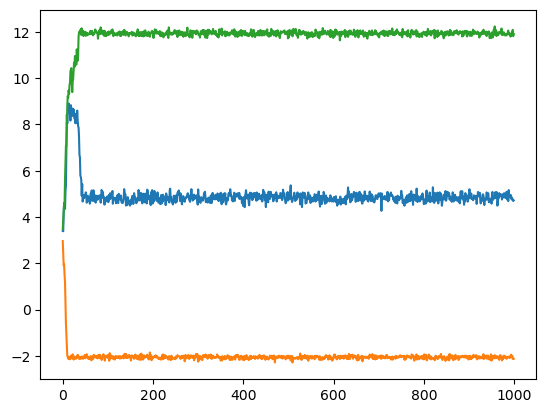

In [28]:
fig = plt.figure()
plt.plot(mu0)
plt.plot(mu1)
plt.plot(mu2)
plt.show()